# Batters by pitch for ALL teams in postseason

# *Setup*

In [3]:
import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import *

pbp_df = pd.read_csv('../cleaned/pitch_by_pitch.csv')
games_df = pd.read_csv('../cleaned/games.csv')
batters_df = pd.read_csv('../cleaned/batters.csv')
con = duckdb.connect()

┌────────────┬────────────────────┐
│ pitch_type │     pitch_name     │
│  varchar   │      varchar       │
├────────────┼────────────────────┤
│ CH         │ Change-up          │
│ CU         │ Curveball          │
│ FC         │ Cutter             │
│ FF         │ Four-Seam Fastball │
│ FS         │ Splitter           │
│ KC         │ Knuckle Curve      │
│ SI         │ Sinker             │
│ SL         │ Slider             │
│ ST         │ Sweeper            │
│ SV         │ Slurve             │
├────────────┴────────────────────┤
│ 10 rows               2 columns │
└─────────────────────────────────┘



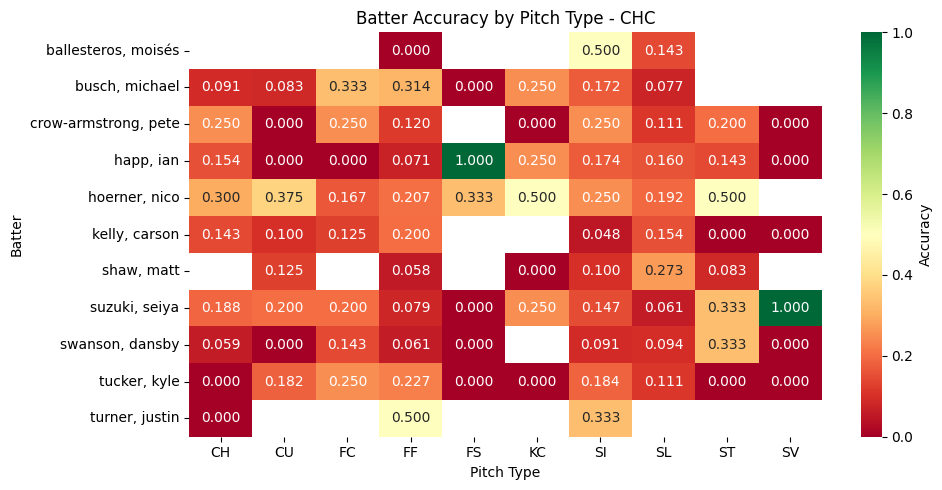

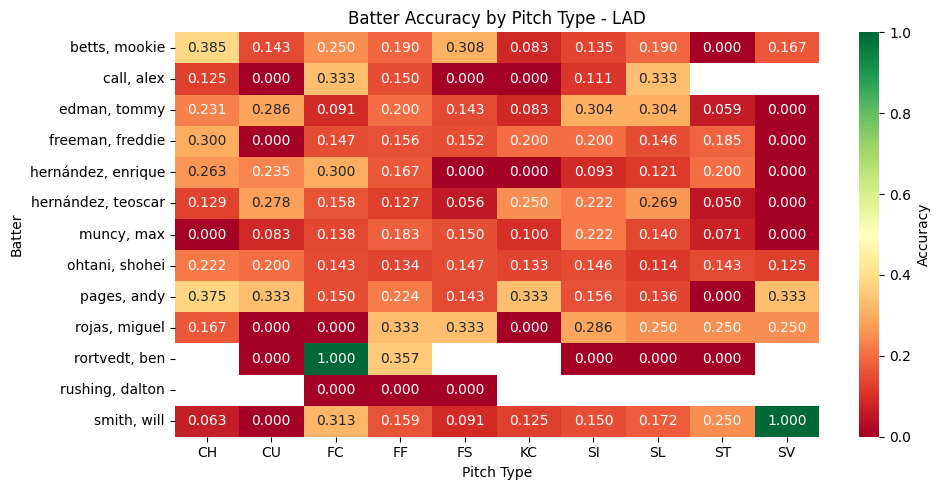

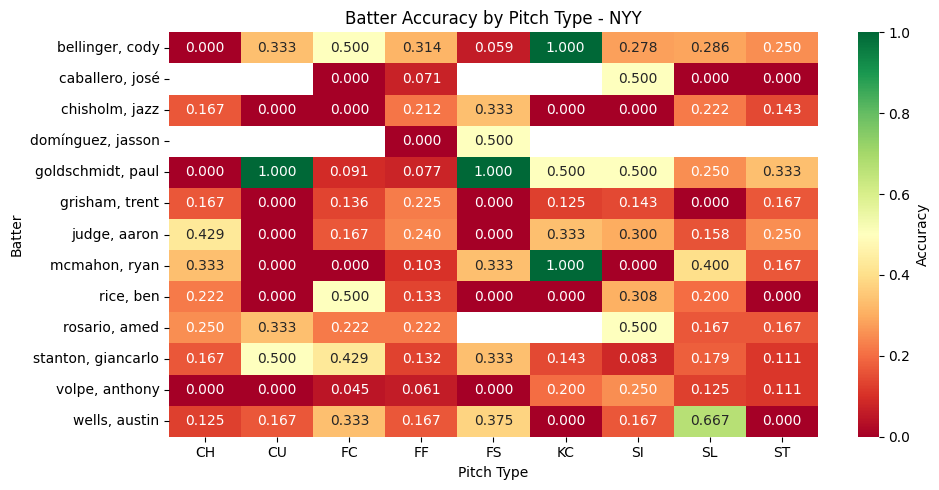

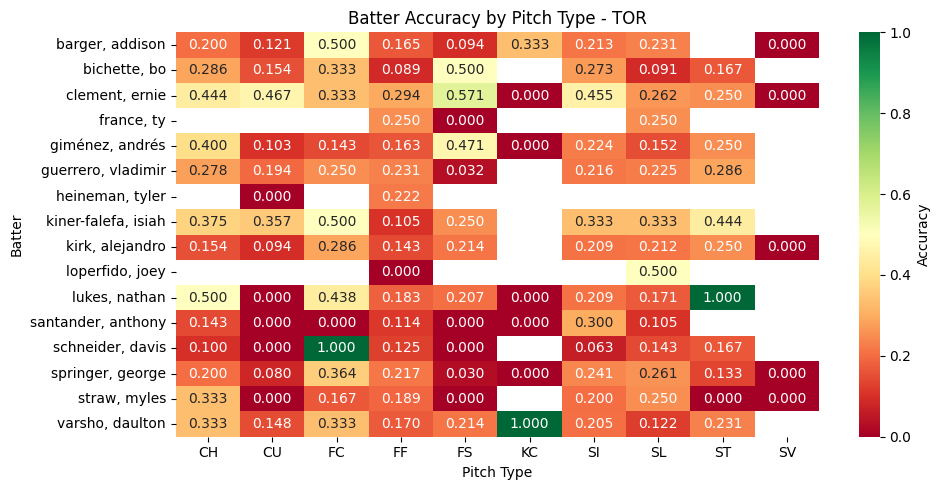

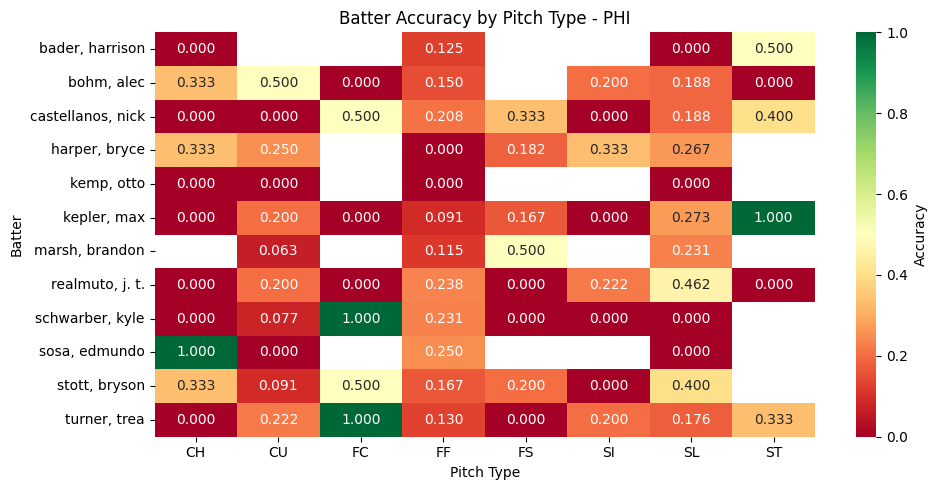

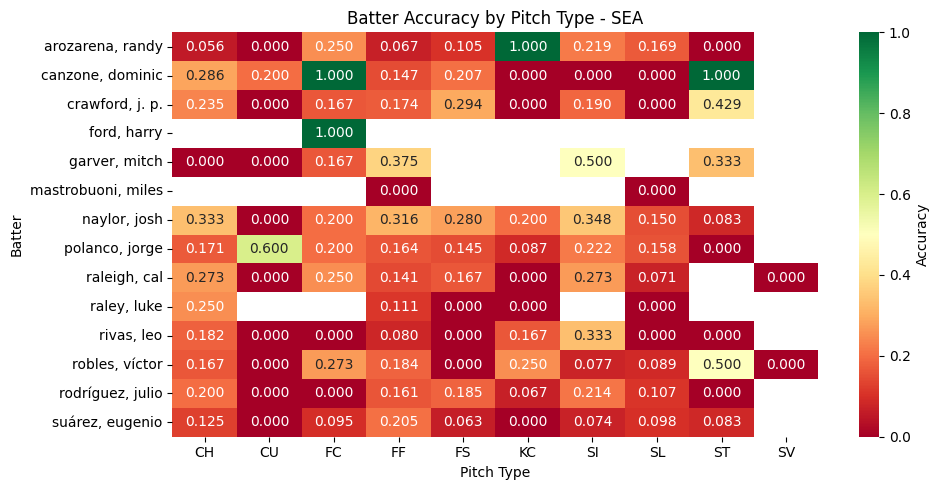

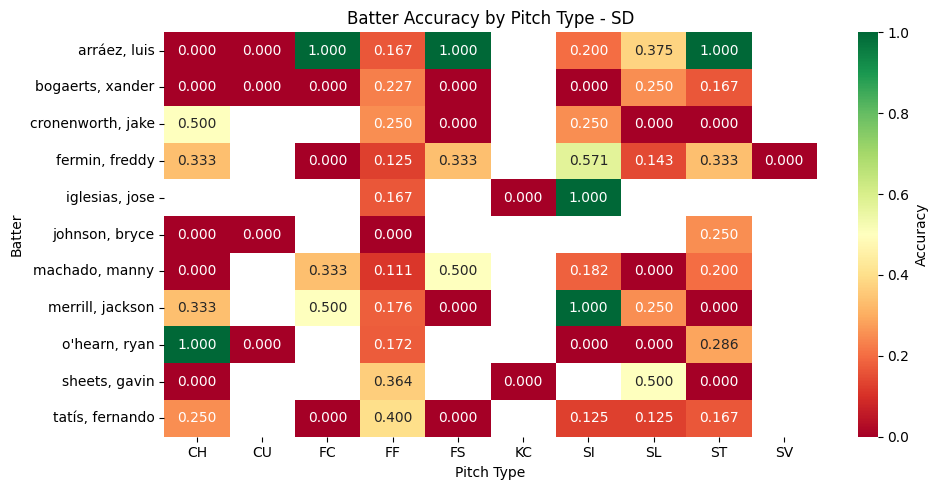

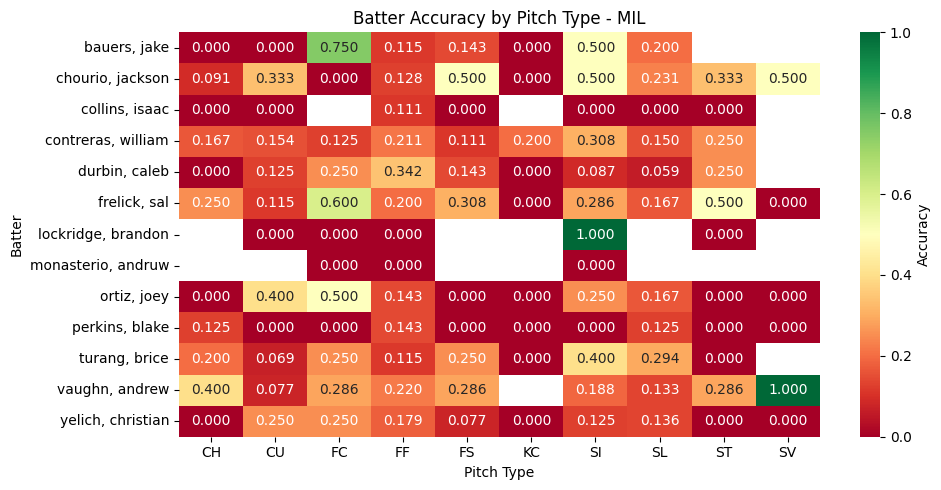

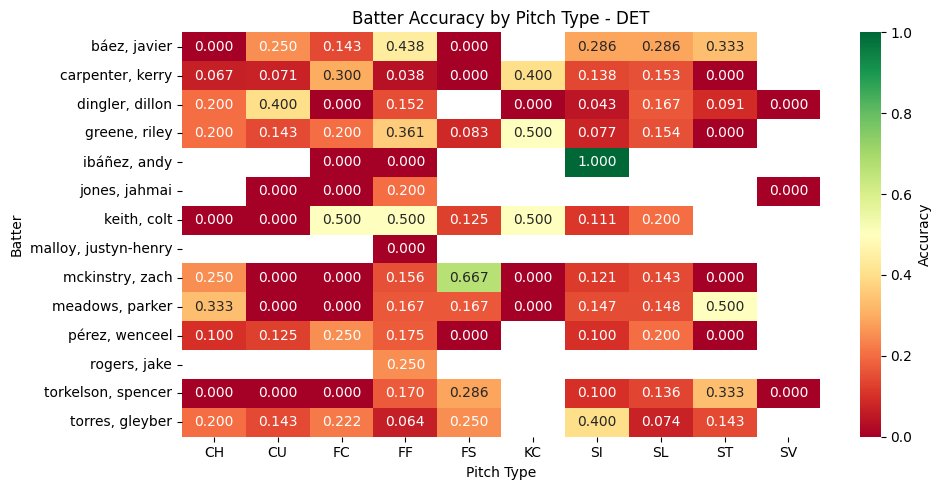

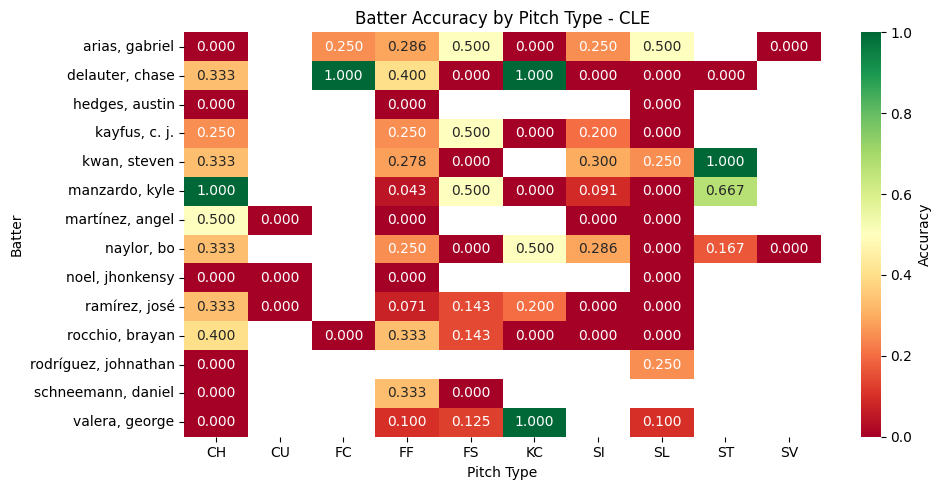

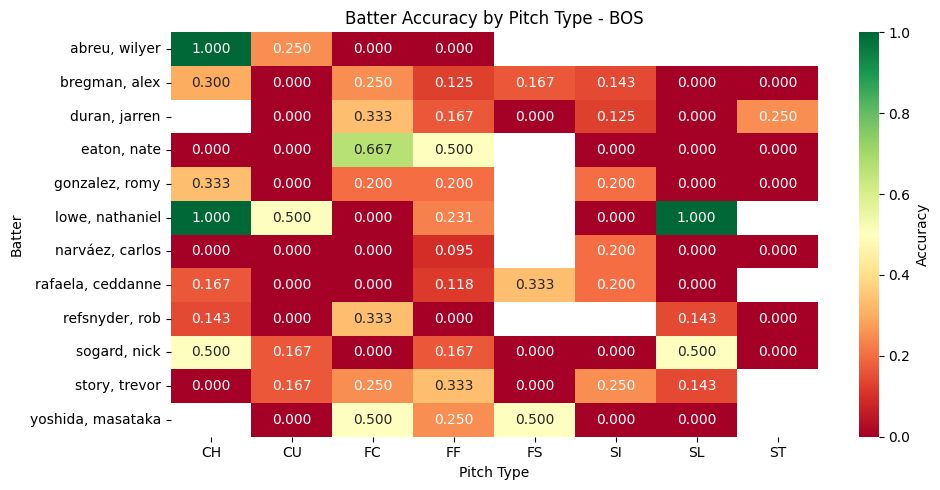

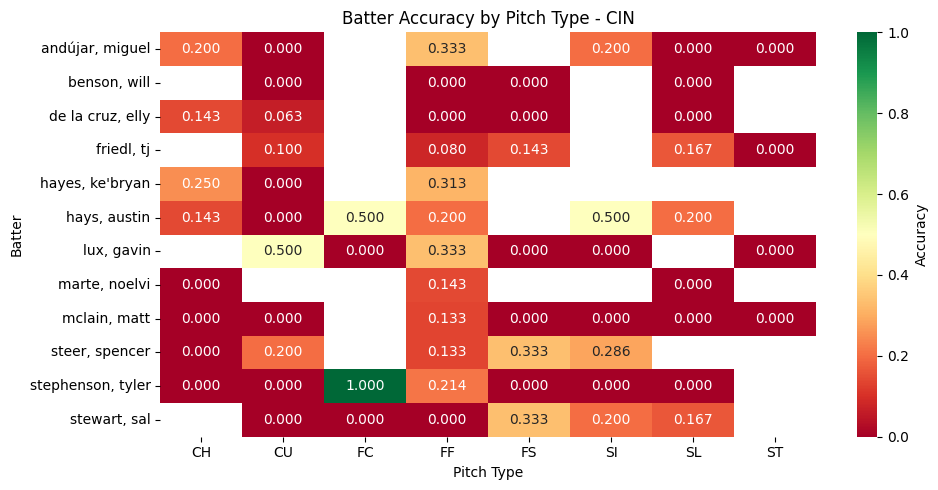

In [6]:
# batter accuracy on type of pitch
import matplotlib.pyplot as plt
import seaborn as sns

# output variables: batting_average (on pitch type)
ba_pitch_type = con.sql("""
        SELECT
            batter,
            pitch_type,
            COUNT(*) as num_pitches_seen,
            SUM(CASE WHEN events IN ('single','double','triple','home_run') OR description = 'hit_into_play' THEN 1 ELSE 0 END) as num_hits,
            SUM(CASE WHEN description IN ('called_strike') THEN 1 ELSE 0 END) as strike_watching,
            SUM(CASE WHEN description IN ('foul', 'strike_swinging') THEN 1 ELSE 0 END) as strike_swinging,
            ROUND(SUM(CASE WHEN events IN ('single','double','triple','home_run') OR description = 'hit_into_play' THEN 1 ELSE 0 END) * 1.0 / COUNT(*), 3) AS accuracy
        FROM pbp_df
        GROUP BY batter, pitch_type
        ORDER BY batter, pitch_type;
        """).to_df()

batter_data = ba_pitch_type.merge(batters_df, left_on = 'batter', right_on = 'batter_id', how = 'left').drop(columns = ['batter_id'])


#print out legend (names of the variables)
print(con.sql("""
    SELECT DISTINCT
        pitch_type,
        CASE 
            WHEN pitch_type = 'AB' THEN 'Automatic Ball'
            WHEN pitch_type = 'AS' THEN 'Automatic Strike'
            WHEN pitch_type = 'CH' THEN 'Change-up'
            WHEN pitch_type = 'CU' THEN 'Curveball'
            WHEN pitch_type = 'EP' THEN 'Eephus'
            WHEN pitch_type = 'FC' THEN 'Cutter'
            WHEN pitch_type = 'FF' THEN 'Four-Seam Fastball'
            WHEN pitch_type = 'FO' THEN 'Forkball'
            WHEN pitch_type = 'FS' THEN 'Splitter'
            WHEN pitch_type = 'FT' THEN 'Two-Seam Fastball'
            WHEN pitch_type = 'GY' THEN 'Gyroball'
            WHEN pitch_type = 'IN' THEN 'Intentional Ball'
            WHEN pitch_type = 'KC' THEN 'Knuckle Curve'
            WHEN pitch_type = 'KN' THEN 'Knuckleball'
            WHEN pitch_type = 'NP' THEN 'No Pitch'
            WHEN pitch_type = 'PO' THEN 'Pitchout'
            WHEN pitch_type = 'SC' THEN 'Screwball'
            WHEN pitch_type = 'SI' THEN 'Sinker'
            WHEN pitch_type = 'SL' THEN 'Slider'
            WHEN pitch_type = 'ST' THEN 'Sweeper'
            WHEN pitch_type = 'SV' THEN 'Slurve'
            ELSE 'Unknown'
        END AS pitch_name
    FROM pbp_df
    ORDER BY pitch_type
"""))

teams = batter_data['team_name'].unique()

for team in teams:
    df_team = batter_data[batter_data['team_name'] == team]
    heatmap_data = df_team.pivot(index = 'full_name', columns = 'pitch_type', values = 'accuracy')
    
    plt.figure(figsize=(10, 5)) 
    sns.heatmap(heatmap_data, annot = True, fmt = ".3f", cmap = 'RdYlGn', cbar_kws = {'label':'Accuracy'}, vmin = 0, vmax = 1)
    plt.title(f'Batter Accuracy by Pitch Type - {team}')
    plt.xlabel('Pitch Type')
    plt.ylabel('Batter')
    plt.tight_layout()
    plt.show()

# GOING FURTHER
- Use some sort of analysis tool to figure out the best pitch to throw to each team/player
- Even could go further and match up pitchers to lineups